In [1]:
import numpy as np 
import pandas as pd  
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

import warnings
warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/wine-quality/winequality.names
/kaggle/input/wine-quality/winequality-white.csv
/kaggle/input/wine-quality/winequality-red.csv


# Data load 

In [2]:
TARGET = 'quality'
seed = 0

#Load data file
orig_data = pd.read_csv('/kaggle/input/wine-quality/winequality-red.csv', sep=';')

In [3]:
orig_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


### Target

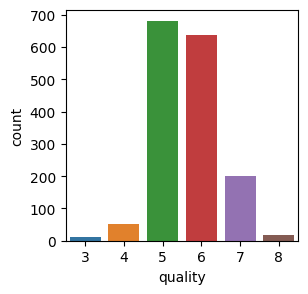

In [4]:
#Target 
plt.figure(figsize=(3,3))
sns.countplot(data=orig_data, x=TARGET)
plt.show()

### Plots: Chars vs Target

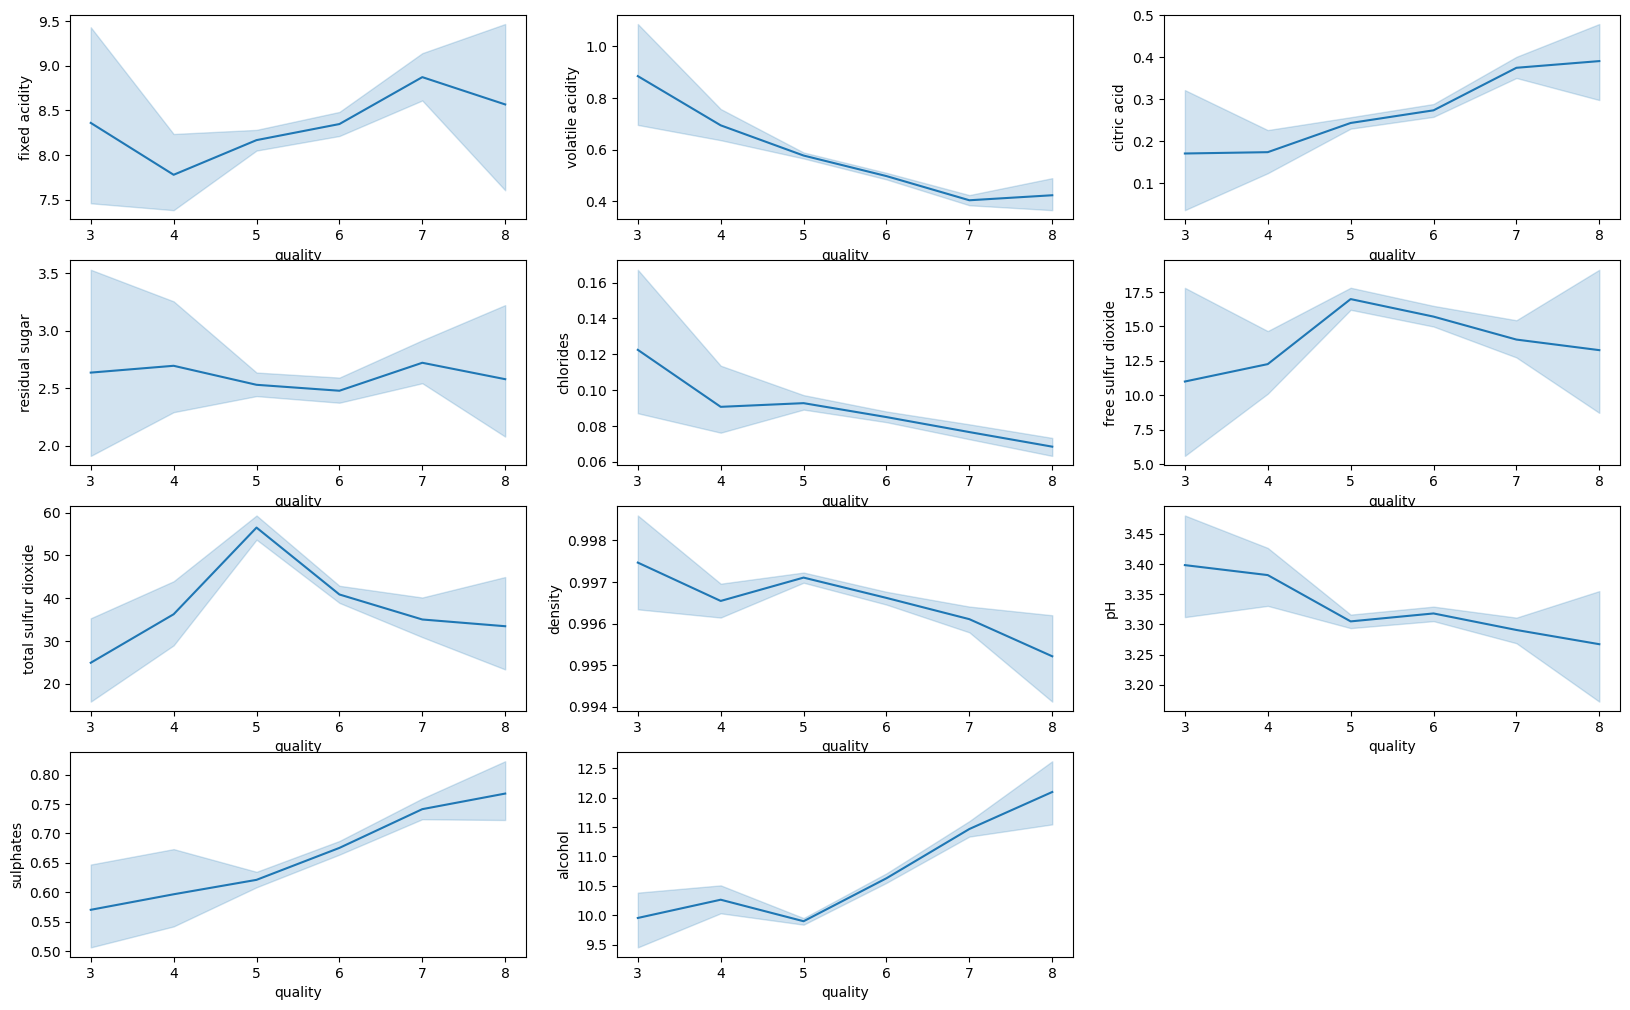

In [5]:
index = 0
plt.figure(figsize=(20,25))
for feature in orig_data.columns:
    if feature != TARGET:
        index += 1
        plt.subplot(8,3,index)
        sns.lineplot(data=orig_data, y=feature, x=TARGET)
plt.show()

### Looking for correlations

<Axes: >

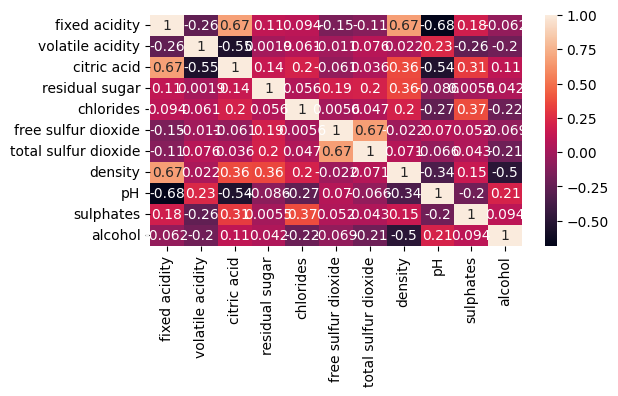

In [6]:
corr = orig_data.drop(TARGET, axis=1).corr()
plt.subplots(figsize=(6,3))
sns.heatmap(corr, annot=True) 

# Pre-processor & Split

In [7]:
from sklearn.preprocessing import OneHotEncoder, RobustScaler  
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

numerical_transformer = RobustScaler()  
categorical_transformer = OneHotEncoder(categories='auto' , sparse_output = False, handle_unknown = "ignore") 

categorical_cols = [ ]
numerical_cols =   ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
                   'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
                   'pH', 'sulphates', 'alcohol'] 
    
preprocessor = ColumnTransformer(transformers = [("ohe", categorical_transformer, categorical_cols), ("scaler", numerical_transformer, numerical_cols)], remainder = "drop", verbose_feature_names_out = False).set_output(transform = "pandas") 

train = orig_data.drop({TARGET}, axis=1)
target = orig_data[TARGET]

train_prep = preprocessor.fit_transform(train)

X_train, X_valid, y_train, y_valid = train_test_split( train_prep, target, test_size=0.1, random_state = seed) 

# Model

In [8]:
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, accuracy_score
from lightgbm import LGBMClassifier 

def lgbm_cl_bo(n_estimators, max_depth, learning_rate):
    
    params = {}
    params['n_estimators'] = round(n_estimators)
    params['learning_rate'] = learning_rate
    params['max_depth'] = round(max_depth)
                      
    loop_model = LGBMClassifier(**params, random_state=seed)
    loop_model.fit(X_train, y_train) 
    
    y_pred_test = loop_model.predict(X_valid)   
    score = accuracy_score(y_valid, y_pred_test)
    
    return score

params_lgbm = { 'n_estimators': (100, 1000) , 
                'max_depth': ( 10,  20),
                'learning_rate': ( 0.001,  0.1)}          

In [9]:
lgbm_bo = BayesianOptimization(lgbm_cl_bo, params_lgbm, random_state=seed)
lgbm_bo.maximize(n_iter=10, init_points=20)   
pmax_bayes = lgbm_bo.max['params']

|   iter    |  target   | learni... | max_depth | n_esti... |
-------------------------------------------------------------
| 1         | 0.7063    | 0.05533   | 17.15     | 642.5     |
| 2         | 0.6813    | 0.05494   | 14.24     | 681.3     |
| 3         | 0.675     | 0.04432   | 18.92     | 967.3     |
| 4         | 0.6813    | 0.03896   | 17.92     | 576.0     |
| 5         | 0.6687    | 0.05724   | 19.26     | 163.9     |
| 6         | 0.6875    | 0.009626  | 10.2      | 849.4     |
| 7         | 0.6687    | 0.07804   | 18.7      | 980.8     |
| 8         | 0.6937    | 0.08012   | 14.61     | 802.5     |
| 9         | 0.675     | 0.01271   | 16.4      | 229.0     |
| 10        | 0.6937    | 0.09452   | 15.22     | 473.2     |
| 11        | 0.6687    | 0.02719   | 17.74     | 510.5     |
| 12        | 0.6875    | 0.05727   | 10.19     | 655.9     |
| 13        | 0.6937    | 0.0616    | 16.17     | 949.4     |
| 14        | 0.6813    | 0.0685    | 13.6      | 493.3     |
| 15    

In [10]:
model = LGBMClassifier (n_estimators = round(pmax_bayes['n_estimators']),  learning_rate = pmax_bayes['learning_rate'],  
                        max_depth = round(pmax_bayes['max_depth']), random_state = seed)   

model.fit(X_train, y_train)

LGBMClassifier(learning_rate=0.055332536888805156, max_depth=17,
               n_estimators=642, random_state=0)

In [11]:
y_pred_train = model.predict(X_train)  
y_pred_test = model.predict(X_valid)   

print("Accuracy: ", accuracy_score(y_valid, y_pred_test))

Accuracy:  0.70625


### Confusion Matrix

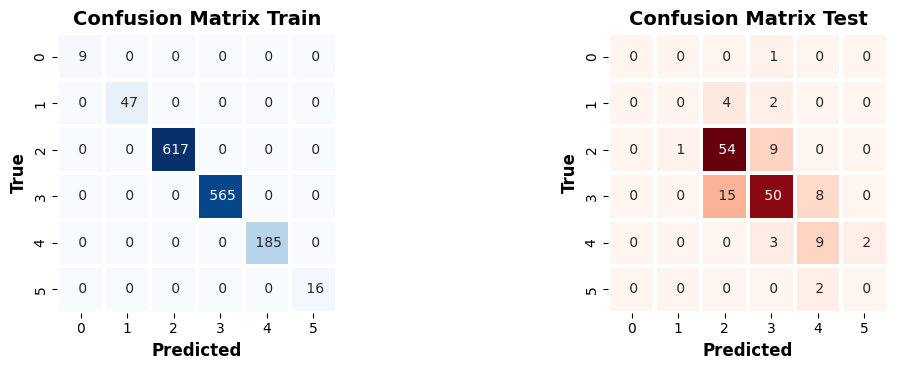

In [12]:
from sklearn.metrics import confusion_matrix 

confusion_matrix_train = confusion_matrix(y_train,y_pred_train)
confusion_matrix_test = confusion_matrix(y_valid, y_pred_test)

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 3.8))
ax = ax.flat
sns.heatmap(confusion_matrix_train, cmap = "Blues", cbar = False, linewidths = 1.5, annot = True, fmt = ' ', square = True, ax = ax[0], )
ax[0].set_xlabel("Predicted", fontsize = 12, fontweight = "bold", color = "black")
ax[0].set_ylabel("True", fontsize = 12, fontweight = "bold", color = "black")
ax[0].set_title("Confusion Matrix Train", fontsize = 14, fontweight = "bold", color = "black")

sns.heatmap(confusion_matrix_test, cmap = "Reds", annot = True, fmt = ' ', cbar = False, linewidths = 1.5, square = True, ax = ax[1])
ax[1].set_xlabel("Predicted", fontsize = 12, fontweight = "bold", color = "black")
ax[1].set_ylabel("True", fontsize = 12, fontweight = "bold", color = "black")
ax[1].set_title("Confusion Matrix Test", fontsize = 14, fontweight = "bold", color = "black")

fig.tight_layout()
fig.show()

### Feature Importances

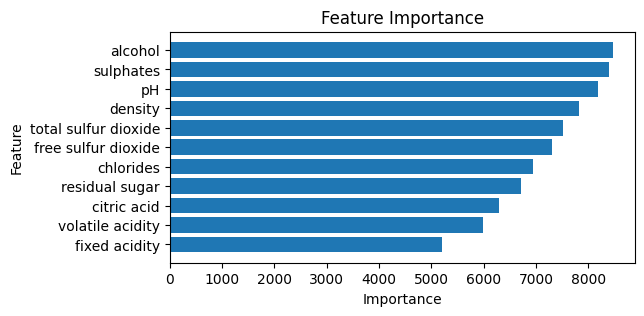

In [13]:
importances = model.feature_importances_
sorted_idx = importances.argsort()

# Crating a Data Frame with the feartures in the training set
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Creating the Feature importance Table
plt.figure(figsize=(6, 3))
plt.barh(feature_importance_df['Feature'], importances[sorted_idx] )

plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()